In [137]:
# INSTRUCTIONS:
#
# 1. Run tracy
#   ./tracy/capture/build/unix/capture-release -f -o orbslam.tracy
# 2. Run system
#   Darvis:
#     cargo run --release ~/datasets/kitti_00_0/ config.yaml
#     (after system is done) cp results/output.log ../../results/darvis-output.txt
#   ORB SLAM3:
#     ./Examples/Monocular/mono_kitti Vocabulary/ORBvoc.txt Examples/Monocular/KITTI00-02.yaml ~/datasets/kitti_00_0/ | tee ../results/orbslam-output.txt
# 
# To find where the extra stats are printed, look for the strings "MAP INFO:" and "LBA:" in source code.

darvis_home = "/home/sofiya/darvis-home/"
output_files = {
    "orbslam-10fps": {
        "tracy": "results/orbslam-10fps.tracy",
        "output": "results/orbslam-10fps.txt"
    },
    "darvis-10fps": {
        "tracy": "results/darvis-10fps.tracy",
        "output": "results/darvis-10fps.txt"
    },
    "darvis fxhasher": {
        "tracy": "results/darvis-fxhash.tracy",
    },
    "darvis seahash": {
        "tracy": "results/darvis-seahasher.tracy",
    },
    "darvis default hash": {
        "tracy": "results/darvis-defaulthash.tracy"
    }
}
        

In [138]:
import subprocess
import matplotlib.pyplot as plt

def ns_to_ms(ns_str):
    return float(ns_str) / 1000000

#### CSVs ####
def process_csv_statistics(csv):
    data = {}
    for line in csv[1:]:
        name, src_file, src_line, total_ns, total_perc, counts, mean_ns, min_ns, max_ns, std_ns = line.split(",")
        data[name] = {
            "mean": ns_to_ms(mean_ns),
            "std": ns_to_ms(std_ns),
            "counts": counts
        }
    return data

def process_csv_unaggregated(csv, process_names):
    data = {}
    for line in csv[1:]:
        name, src_file, src_line, ns_since_start, exec_time_ns = line.split(",")
        if name in data:
            data[name]["dur"].append(ns_to_ms(exec_time_ns))
            data[name]["time"].append(ns_to_ms(ns_since_start))
        else:
            data[name] = {
                "dur": [ns_to_ms(exec_time_ns)],
                "time": [ns_to_ms(ns_since_start)]
            }
            process_names.add(name)
    return data, process_names

#### REGULAR OUTPUT FILES ####
def new_extra_data():
    # Just so we have the same formatting for both darvis and orbslam
    return {
        "map info": {
            "kfs": [],
            "mps": [],
            "avg_mps_per_kf": [],
            "time": [],
        },
        "LBA": {
            "kfs to optimize": [],
            "fixed kfs": [],
            "mps to optimize": [],
            "edges": [],
            "time": [],
        }
    }

def process_output_file_orbslam(file):
    start_time = 0
    data = new_extra_data()
    for line in open(file, "r"):
        try:
            if "START TIME" in line:
                start_time = float(line.split(":")[1]) / 1000 # ms to s
            elif "MAP INFO" in line:
                _, garb = line.split(":")
                time, kfs, mps, avg_mps_per_kf = garb.split(",")
                data["map info"]["kfs"].append(float(kfs))
                data["map info"]["mps"].append(float(mps))
                data["map info"]["avg_mps_per_kf"].append(float(avg_mps_per_kf))
                data["map info"]["time"].append((float(time) / 1000) - start_time)
                print(line)
            elif "LBA" in line:
                _, garb = line.split(":")
                time, kfs_to_optimize, fixed_kfs, mps_to_optimize, edges = garb.split(",")
                data["LBA"]["kfs to optimize"].append(float(kfs_to_optimize))
                data["LBA"]["fixed kfs"].append(float(fixed_kfs))
                data["LBA"]["mps to optimize"].append(float(mps_to_optimize))
                data["LBA"]["edges"].append(float(edges))
                data["LBA"]["time"].append((float(time) / 1000) - start_time)
        except ValueError:
            print(line)
    return data
        
def process_output_file_darvis(file):
    start_time = 0    
    data = new_extra_data()
    for line in open(file, "r"):
        try:
            if "Tracking working on frame 0" in line:
                start_time = float(line.split(" ")[0].split("[")[1].strip())
            elif "MAP INFO" in line:
                time = line.split(" ")[0].split("[")[1].strip()
                _, garb = line.split("MAP INFO:")
                kfs, mps, avg_mps_per_kf = garb.split(",")
                data["map info"]["kfs"].append(float(kfs))
                data["map info"]["mps"].append(float(mps))
                data["map info"]["avg_mps_per_kf"].append(float(avg_mps_per_kf))
                data["map info"]["time"].append(float(time) - start_time)
            elif "LBA" in line:
                time = line.split(" ")[0].split("[")[1].strip()
                _, garb = line.split("LBA:")
                kfs_to_optimize, fixed_kfs, mps_to_optimize, edges = garb.split(",")
                data["LBA"]["kfs to optimize"].append(float(kfs_to_optimize))
                data["LBA"]["fixed kfs"].append(float(fixed_kfs))
                data["LBA"]["mps to optimize"].append(float(mps_to_optimize))
                data["LBA"]["edges"].append(float(edges))
                data["LBA"]["time"].append(float(time) - start_time)
        except ValueError:
            print(line)
    return data
    
results = {}
process_names = set()
for key in output_files:
    # Tracy
    tracy_fn = darvis_home + output_files[key]["tracy"]
    csv_statistics = subprocess \
        .run([darvis_home +"tracy/csvexport/build/unix/csvexport-release", tracy_fn], stdout=subprocess.PIPE) \
        .stdout \
        .decode('utf-8') \
        .split("\n")[1:-1] # First line is key, last line is empty
    csv_unaggregated_counts = subprocess \
        .run([darvis_home +"tracy/csvexport/build/unix/csvexport-release", "-u", tracy_fn], stdout=subprocess.PIPE) \
        .stdout \
        .decode('utf-8') \
        .split("\n")[1:-1] # First line is key, last line is empty
    times, process_names = process_csv_unaggregated(csv_unaggregated_counts, process_names)
    
    # Regular output
    if "output" in output_files[key]:
        output_fn = darvis_home + output_files[key]["output"]
        if "darvis" in key:
            extra_stats = process_output_file_darvis(output_fn)
        else:
            extra_stats = process_output_file_orbslam(output_fn)
    else:
        print(key, "does not have output file")
        extra_stats = new_extra_data()

    results[key] = {
        "times": times,
        "extra stats": extra_stats
    }


MAP INFO:1705448126815,2,413,413

MAP INFO:1705448126843,2,701,679

MAP INFO:1705448126846,2,701,679

MAP INFO:1705448126873,2,720,697.5

MAP INFO:1705448126961,3,603,556.333

MAP INFO:1705448127030,3,1416,1238

MAP INFO:1705448127108,4,1335,1124.75

Sofiya mDescriptors in frame [32 x 9643]MAP INFO:1705448127212,4,2030,1623

MAP INFO:1705448127238,5,1958,1513.8

MAP INFO:1705448127375,5,2786,2042

MAP INFO:1705448127515,6,2619,1845.67

MAP INFO:1705448127683,6,3361,2258.33

MAP INFO:1705448127780,7,3121,2026.57

MAP INFO:1705448127981,7,3796,2295.29

MAP INFO:1705448128069,8,3613,2119.88

MAP INFO:1705448128299,8,4280,2332.75

MAP INFO:1705448128429,9,4045,2077.11

MAP INFO:1705448128545,9,4152,2100.33

MAP INFO:1705448128681,10,3746,1852.1

MAP INFO:1705448128790,10,3892,1880.1

MAP INFO:1705448128917,11,3823,1730.45

MAP INFO:1705448129032,11,3952,1756.55

MAP INFO:1705448129154,12,3890,1626.33

MAP INFO:1705448129278,12,4017,1652

MAP INFO:1705448129389,13,3953,1534.38

MAP INFO:170

In [139]:
def draw_duration_graphs(results):
    # Draws every single process
    plt.figure(figsize=(8, 6))
    relevant_process_names = [
        "track",
        "local_mapping",
        "create_new_mappoints",
        "mappoint_culling",
        "keyframe_culling",
        "local_bundle_adjustment"
    ]
    for process in relevant_process_names:
        try:
            for exp in results:
                x_values = results[exp]["times"][process]["time"]
                y_values = results[exp]["times"][process]["dur"]
                plt.plot(x_values, y_values, label=exp, marker='o', linestyle='-', markersize=6)

            plt.xlabel('Time Since Beginning of Execution')
            plt.ylabel('Duration')
            plt.title("Duration of " + process)
            plt.legend()
            plt.show()
        except:
            print("Does not have key", process);

def plot_one_process(experiments, process):
    # Draws just one process if you know what you want
    plt.figure(figsize=(8, 6))
    for exp in experiments:
        x_values = experiments[exp]["times"][process]["time"]
        y_values = experiments[exp]["times"][process]["dur"]
        plt.plot(x_values, y_values, label=exp, marker='o', linestyle='-', markersize=6)

    plt.xlabel('Time Since Beginning of Execution')
    plt.ylabel('Duration')
    plt.title("Duration of " + process)
    plt.legend()
    plt.show()

def plot_one_extra_stat(experiments, stat_name, secondary_stat_name):
    # Plot non-timing stats from the regular output file
    plt.figure(figsize=(8, 6))
    for exp in experiments:
        only_stats = experiments[exp]["extra stats"][stat_name]
        x_values = only_stats["time"]
        y_values = only_stats[secondary_stat_name]
        label = exp + " , " + secondary_stat_name
        plt.plot(x_values, y_values, label=label, marker='o', linestyle='-', markersize=6)

    plt.xlabel('Time Since Beginning of Execution')
    plt.ylabel('Amount')
    plt.title(stat_name + ", " + secondary_stat_name)
    plt.legend()
    plt.show()


In [140]:
print("Comparing hashing strategies")
# experiments_I_care_about = dict((k, results[k]) for k in ('darvis fxhasher', 'darvis seahash', 'darvis default hash'))
# draw_duration_graphs(experiments_I_care_about)

Comparing hashing strategies


Comparing darvis vs. orbslam


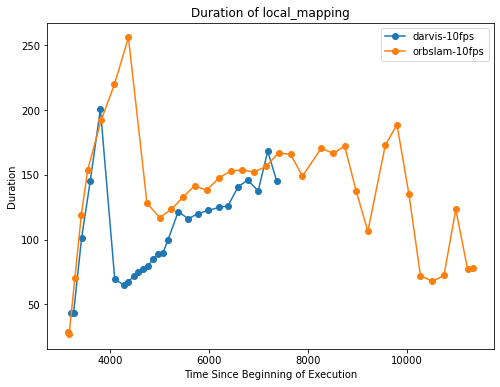

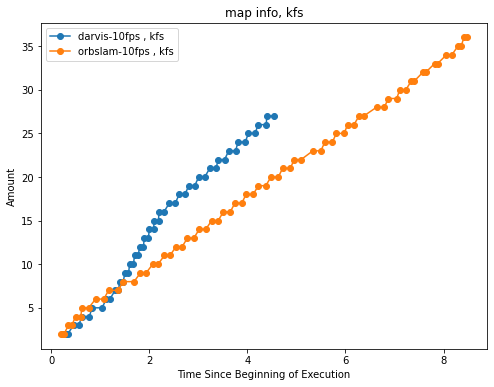

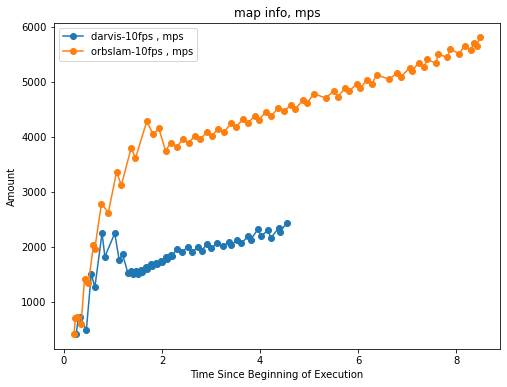

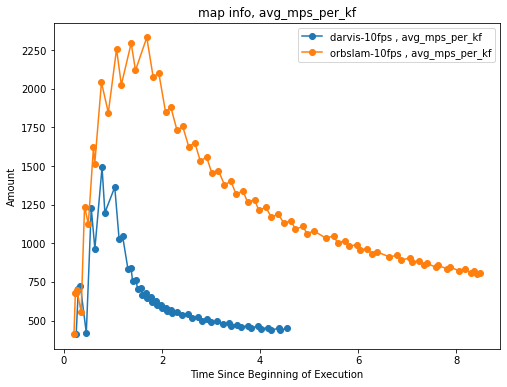

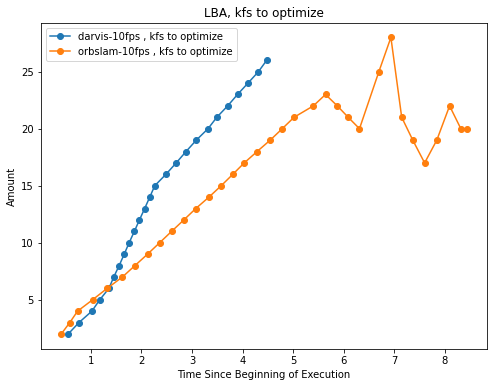

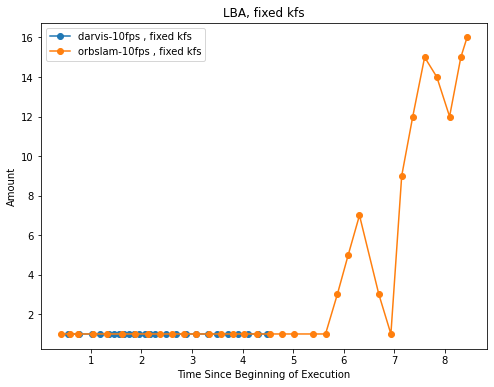

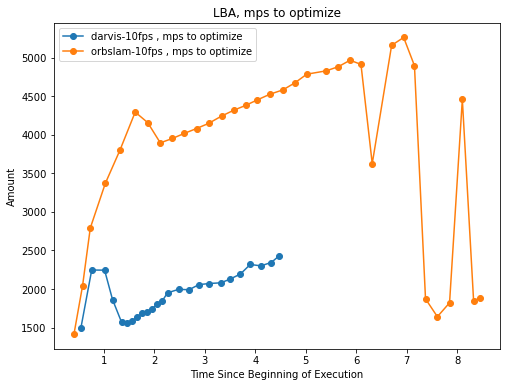

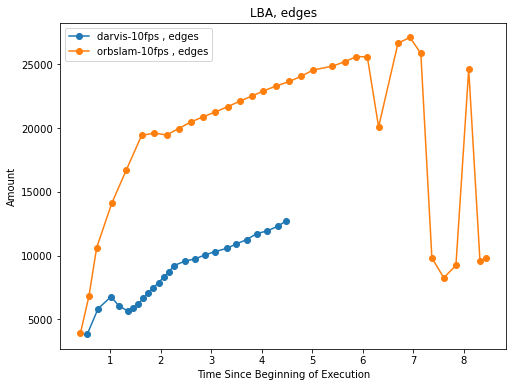

In [141]:
print("Comparing darvis vs. orbslam")
experiments_I_care_about = dict((k, results[k]) for k in ('darvis-10fps', 'orbslam-10fps'))
# draw_duration_graphs(experiments_I_care_about),
plot_one_process(experiments_I_care_about, "local_mapping")
plot_one_extra_stat(experiments_I_care_about, "map info", "kfs")
plot_one_extra_stat(experiments_I_care_about, "map info", "mps")
plot_one_extra_stat(experiments_I_care_about, "map info", "avg_mps_per_kf")


plot_one_extra_stat(experiments_I_care_about, "LBA", "kfs to optimize")
plot_one_extra_stat(experiments_I_care_about, "LBA", "fixed kfs")
plot_one_extra_stat(experiments_I_care_about, "LBA", "mps to optimize")
plot_one_extra_stat(experiments_I_care_about, "LBA", "edges")